In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
from scipy.fftpack import fft,ifft
from scipy.signal.windows import hamming
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sounddevice as sd
import soundfile as sf
import librosa
import librosa.display
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,Input,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics

2023-12-01 14:08:14.817235: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 14:08:14.848212: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 14:08:15.014112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 14:08:15.014163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 14:08:15.014948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
max_sample_size = 192 # max size of each audio sample
sample_rate = 44100 
dt = 0.032 # time interval
win_size = int(sample_rate * dt) # window size
n_fft = win_size # num of sample in fft
hop_length = int(0.5 * win_size) # hop_length => 50% overlap
n_mels = 192 # number of Mel bin - as number of features
num_sample_with_hop = max_sample_size * hop_length
window=hamming(win_size)

In [3]:
def get_mel_feature(audio_file):
    sample, _ = librosa.load(audio_file, sr=sample_rate)
    if (sample.shape[0] < num_sample_with_hop):
        print(audio_file)
        return None
        
    sample = sample[:num_sample_with_hop]
    # calculate mel spectrogram
    S = librosa.feature.melspectrogram(y=sample, sr=sample_rate, n_fft=n_fft, 
                                       hop_length=hop_length, n_mels=n_mels,
                                       window=hamming)
    S_DB = librosa.power_to_db(S, ref=np.max)
    # print(S_DB.shape)
    
    # scale
    max_db = np.max(S_DB)
    min_db = np.min(S_DB)
    S_DB = (S_DB - min_db) / (max_db - min_db)

    return S_DB

In [6]:
train_data_dir = "data/train_data"
test_data_dir = "data/test_data"
labels = ["cars", "trams"]
car_audio_list = os.listdir(os.path.join(train_data_dir, labels[0]))
car_audio_list.sort()
tram_audio_list = os.listdir(os.path.join(train_data_dir, labels[1]))
tram_audio_list.sort()
X_train, y_train = np.empty((0, n_mels, max_sample_size, 1)), np.empty((0,1))
for i, car_audio in enumerate(car_audio_list):
    audio_file = os.path.join(train_data_dir, labels[0], car_audio)
    feature = get_mel_feature(audio_file)
    if (feature is not None):
        feature = np.expand_dims(np.expand_dims(feature, axis=0), axis=-1)
        X_train = np.append(X_train, feature, axis=0)
        y_train = np.append(y_train, np.array([[0]]), axis=0)
    
for i, tram_audio in enumerate(tram_audio_list):
    audio_file = os.path.join(train_data_dir, labels[1], tram_audio)
    feature = get_mel_feature(audio_file)
    if (feature is not None):
        feature = np.expand_dims(np.expand_dims(feature, axis=0), axis=-1)
        X_train = np.append(X_train, feature, axis=0)
        y_train = np.append(y_train, np.array([[1]]), axis=0)


data/train_data/cars/cars_012.wav


In [21]:
car_audio_list[:10]

['car_01.wav',
 'car_02.wav',
 'car_03.wav',
 'car_05.wav',
 'car_06.wav',
 'car_07.wav',
 'car_08.wav',
 'car_09.wav',
 'car_10.wav',
 'car_11.wav']

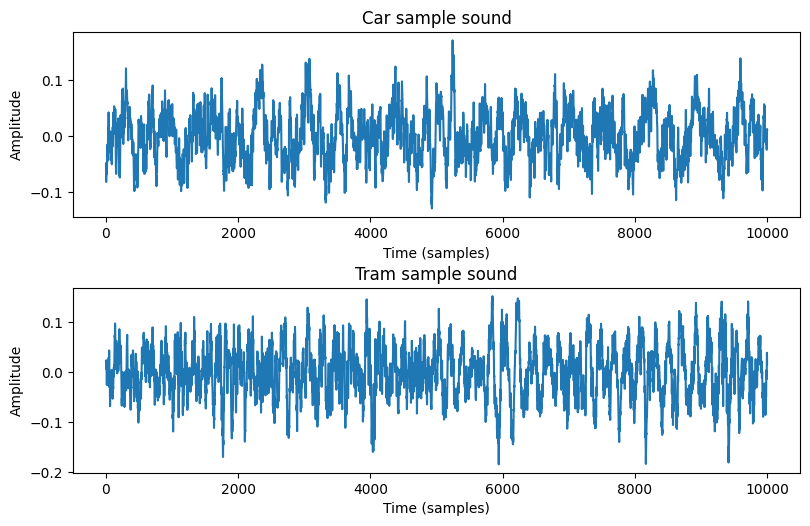

In [10]:
# Show time domain car and tram
sample_ind = 19
audio_file_car = os.path.join(train_data_dir, labels[0], car_audio_list[sample_ind])
audio_file_tram = os.path.join(train_data_dir, labels[1], tram_audio_list[sample_ind])
sample_car, _  = librosa.load(audio_file_car,  sr=sample_rate)
sample_tram, _ = librosa.load(audio_file_tram, sr=sample_rate)

fig, ax = plt.subplots(2,figsize=(8, 5))
fig.tight_layout(h_pad=3)
ax[0].plot(sample_car[5000:15000])
ax[0].set_xlabel("Time (samples)")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Car sample sound")
ax[1].plot(sample_tram[5000:15000])
ax[1].set_xlabel("Time (samples)")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Tram sample sound")
plt.show()

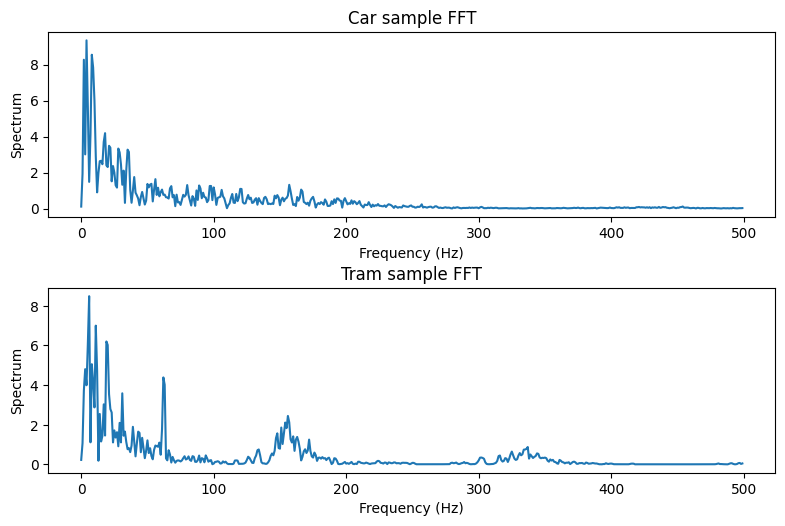

In [11]:
# One window FFT spectrum
fft_sample_car = np.abs(fft(sample_car[5000:5000+win_size]*window, n_fft))
fft_sample_tram = np.abs(fft(sample_tram[5000:5000+win_size]*window, n_fft))
fig, ax = plt.subplots(2,figsize=(8, 5))
fig.tight_layout(h_pad=3)
ax[0].plot(fft_sample_car[:500])
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Spectrum")
ax[0].set_title("Car sample FFT")
ax[1].plot(fft_sample_tram[:500])
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Spectrum")
ax[1].set_title("Tram sample FFT")
plt.show()

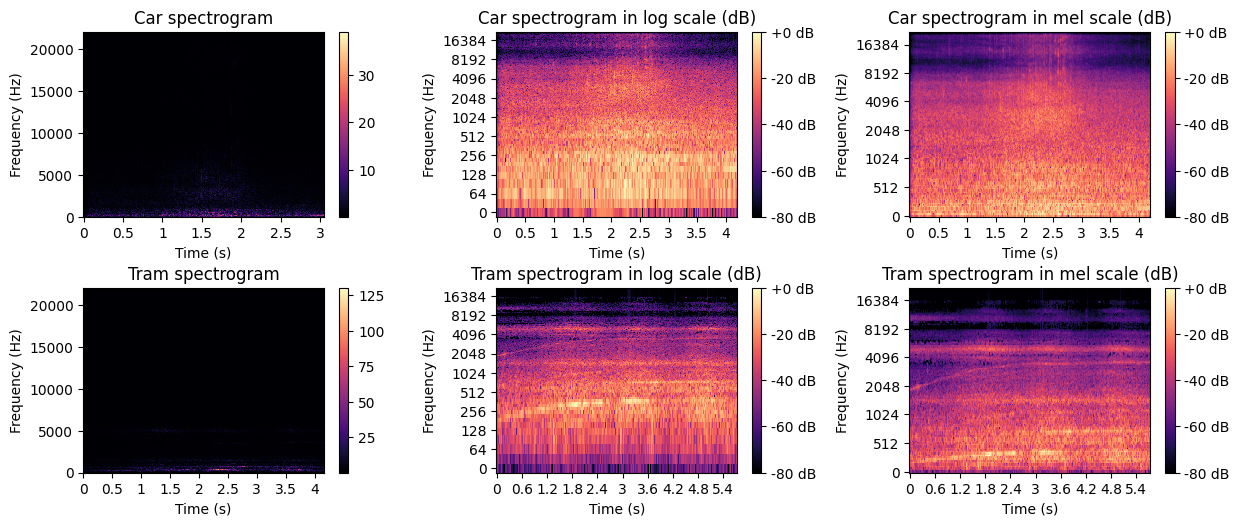

In [12]:
fig, ax = plt.subplots(2,3,figsize=(12, 5))
fig.tight_layout(h_pad=3, w_pad=5)
# CAR SPECTROGRAM
D = np.abs(librosa.stft(sample_car, n_fft=n_fft,  hop_length=hop_length, window=hamming))
im_car = librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='linear', ax=ax[0][0])
ax[0][0].set_xlabel("Time (s)")
ax[0][0].set_ylabel("Frequency (Hz)")
ax[0][0].set_title("Car spectrogram")
plt.colorbar(im_car, ax=ax[0][0])

# CAR LOG SCALED SPECTROGRAM
DB = librosa.amplitude_to_db(D, ref=np.max)
im_car = librosa.display.specshow(DB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax[0][1]);
ax[0][1].set_xlabel("Time (s)")
ax[0][1].set_ylabel("Frequency (Hz)")
ax[0][1].set_title("Car spectrogram in log scale (dB)")
plt.colorbar(im_car, ax=ax[0][1], format='%+2.0f dB')

# CAR MEL SPECTROGRAM
S = librosa.feature.melspectrogram(y=sample_car, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, window=hamming)
S_DB = librosa.power_to_db(S, ref=np.max)
im_car = librosa.display.specshow(S_DB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[0][2]);
ax[0][2].set_xlabel("Time (s)")
ax[0][2].set_ylabel("Frequency (Hz)")
ax[0][2].set_title("Car spectrogram in mel scale (dB)")
plt.colorbar(im_car, ax=ax[0][2], format='%+2.0f dB');

# TRAM SPECTROGRAM
D = np.abs(librosa.stft(sample_tram, n_fft=n_fft,  hop_length=hop_length, window=hamming))
im_tram = librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='linear', ax=ax[1][0])
ax[1][0].set_xlabel("Time (s)")
ax[1][0].set_ylabel("Frequency (Hz)")
ax[1][0].set_title("Tram spectrogram")
plt.colorbar(im_tram,ax=ax[1][0])

# TRAM LOG SCALED SPECTROGRAM
DB = librosa.amplitude_to_db(D, ref=np.max)
im_tram = librosa.display.specshow(DB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax[1][1]);
ax[1][1].set_xlabel("Time (s)")
ax[1][1].set_ylabel("Frequency (Hz)")
ax[1][1].set_title("Tram spectrogram in log scale (dB)")
plt.colorbar(im_tram, ax=ax[1][1], format='%+2.0f dB')

# CAR MEL SPECTROGRAM
S = librosa.feature.melspectrogram(y=sample_tram, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, window=hamming)
S_DB = librosa.power_to_db(S, ref=np.max)
im_tram = librosa.display.specshow(S_DB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[1][2]);
ax[1][2].set_xlabel("Time (s)")
ax[1][2].set_ylabel("Frequency (Hz)")
ax[1][2].set_title("Tram spectrogram in mel scale (dB)")
plt.colorbar(im_tram, ax=ax[1][2], format='%+2.0f dB');


In [13]:
# LOAD TEST DATA
car_audio_list = os.listdir(os.path.join(test_data_dir, labels[0]))
car_audio_list.sort()
tram_audio_list = os.listdir(os.path.join(test_data_dir, labels[1]))
tram_audio_list.sort()
X_test, y_test = np.empty((0, n_mels, max_sample_size, 1)), np.empty((0,1))
for i, car_audio in enumerate(car_audio_list):
    audio_file = os.path.join(test_data_dir, labels[0], car_audio)
    feature = get_mel_feature(audio_file)
    if (feature is not None):
        feature = np.expand_dims(np.expand_dims(feature, axis=0), axis=-1)
        X_test = np.append(X_test, feature, axis=0)
        y_test = np.append(y_test, np.array([[0]]), axis=0)
    
for i, tram_audio in enumerate(tram_audio_list):
    audio_file = os.path.join(test_data_dir, labels[1], tram_audio)
    feature = get_mel_feature(audio_file)
    if (feature is not None):
        feature = np.expand_dims(np.expand_dims(feature, axis=0), axis=-1)
        X_test = np.append(X_test, feature, axis=0)
        y_test = np.append(y_test, np.array([[1]]), axis=0)

In [14]:
X_train, y_train = shuffle(X_train, y_train, random_state=1112)
X_test, y_test = shuffle(X_test, y_test, random_state=2321)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(364, 192, 192, 1)
(364, 1)
(41, 192, 192, 1)
(41, 1)


In [16]:
opt = Adam(learning_rate=0.0001)
batch_size = 16
input_shape = (192,192,1)
callback = EarlyStopping(monitor='val_loss', patience=5)
epochs = 10

In [17]:
model_cnn = Sequential()
model_cnn.add(Input(input_shape))
model_cnn.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation="relu"))
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(16, activation="relu"))
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(1, activation="sigmoid"))
model_cnn.compile(optimizer=opt,loss="binary_crossentropy",metrics=['accuracy'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                   

In [18]:
history = model_cnn.fit(X_train, y_train, epochs=epochs, 
                        batch_size=batch_size, 
                        # validation_data=(X_val, y_val),
                        validation_split=0.1,
                        callbacks=[callback])

Epoch 1/10
21/21 [==============================] - 4s 134ms/step - loss: 0.6864 - accuracy: 0.5260 - val_loss: 0.6842 - val_accuracy: 0.4595
Epoch 2/10
21/21 [==============================] - 3s 128ms/step - loss: 0.6596 - accuracy: 0.5443 - val_loss: 0.6511 - val_accuracy: 0.4595
Epoch 3/10
21/21 [==============================] - 3s 129ms/step - loss: 0.5737 - accuracy: 0.7156 - val_loss: 0.5248 - val_accuracy: 0.8649
Epoch 4/10
21/21 [==============================] - 3s 127ms/step - loss: 0.4041 - accuracy: 0.8685 - val_loss: 0.4420 - val_accuracy: 0.8378
Epoch 5/10
21/21 [==============================] - 3s 128ms/step - loss: 0.3135 - accuracy: 0.8716 - val_loss: 0.3211 - val_accuracy: 0.8919
Epoch 6/10
21/21 [==============================] - 3s 128ms/step - loss: 0.2415 - accuracy: 0.9144 - val_loss: 0.1806 - val_accuracy: 0.9459
Epoch 7/10
21/21 [==============================] - 3s 127ms/step - loss: 0.1423 - accuracy: 0.9572 - val_loss: 0.1206 - val_accuracy: 0.9730
Epoch 

In [19]:
losses, acc = model_cnn.evaluate(X_train, y_train)
print(acc)

12/12 [==============================] - 1s 70ms/step - loss: 0.0329 - accuracy: 0.9918
0.9917582273483276


In [20]:
losses, acc = model_cnn.evaluate(X_test, y_test)
print(acc)

2/2 [==============================] - 0s 29ms/step - loss: 0.5603 - accuracy: 0.8049
0.8048780560493469


In [110]:
y_test_pred = model_cnn.predict(X_test)

2/2 [==============================] - 0s 27ms/step


In [91]:
y_test_pred[y_test_pred >= 0.5] = 1
y_test_pred[y_test_pred < 0.5] = 0
print(y_test_pred.transpose()[0])
print(y_test.transpose()[0])
sum(y_test_pred == y_test) / y_test.shape[0]

[0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
[0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1.]


array([0.85365854])

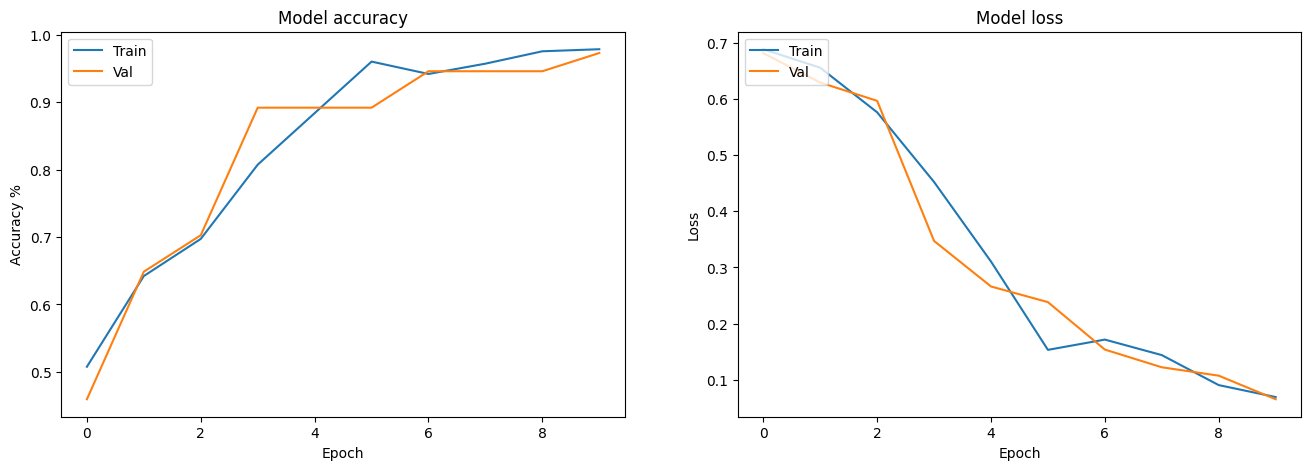

In [92]:
fig, ax = plt.subplots(1,2,figsize=(16, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy %')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')
plt.show()

In [93]:
# Save model with weight
save_path = "cars_trams_model.keras"
model_cnn.save(save_path)

In [66]:
# Load model with weight
model_cnn = tf.keras.models.load_model(save_path)

In [94]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open("model_history.json", 'w'))